# Project III: Structure-from-Motion in 2D
Allegra Gasparetto <br>
2025-05-28

In [1]:
import os
import re
from typing import *
import cv2
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from PIL import Image

## Structure-from-Motion

This project involves the implementation of a Structure-from-Motion pipeline in 2D, which is equivalent to stitching together multiple 2D images of a planar surface.

The pipeline uses a RANSAC-based method to estimate homographies between image pairs based on SIFT feature correspondences.

For a given set of input images, the following steps are performed:
- Extract SIFT keypoints and descriptors for each image.
- Match SIFT features between image pairs and estimate homographies for each pair using RANSAC.
- Select the image pair with the largest number of inliers to define the global coordinate system.
- Compute global homographies by composing relative transformations from the reference image to iteratively add the other images.
- Project keypoints into a common global frame to create a sparse 2D map of the scene.

The main function `run_structure_from_motion(images, threshold)` contain this pipeline.

In [2]:
def run_structure_from_motion(images, threshold):
    """
    Runs the full 2D Structure-from-Motion pipeline on a list of images.

    Parameters:
        images (List[np.ndarray]): list of input images (grayscale or color).
        threshold (float): RANSAC reprojection error threshold for homography estimation.

    Returns:
        ref_image_idx (int): index (1-based) of the reference image chosen as global origin.
        homographies_glob (Dict[int, np.ndarray]): global homographies mapping each image to the reference frame.
        keypoints (List[List[cv2.KeyPoint]]): keypoints detected in each image.
        sparse_points (np.ndarray): Nx2 array of global 2D points from all images.
    """
    
    # Extract SIFT keypoints and descriptors
    keypoints, descriptors = sift_features(images)
    # Estimate homographies and inlier matches between image pairs
    homographies, inliers, inliers_count = pair_homographies(descriptors, keypoints, threshold)
    # Compute global homographies relative to the reference image coordinate system
    homographies_glob, ref_image_idx = compute_global_homographies(homographies, inliers_count, len(images))
    # Project keypoints into the global coordinate system
    sparse_points = keypoints_to_global(keypoints, homographies_glob)
    
    return ref_image_idx, homographies_glob, keypoints, sparse_points

## SIFT feature extraction

This section defines three functions for preprocessing images and extracting features using the Scale-Invariant Feature Transform (SIFT):

- `read_as_grayscale(image_path)`  
  Loads an image and converts it to grayscale.

- `extract_sift_features(image)`  
  Detects keypoints and computes descriptors using OpenCV's implementation of the SIFT algorithm.  
  These features are robust to scale, rotation, and illumination changes.

- `sift_features(image)`  
  Creates a list of keypoints and a list of descriptors from a list of images

  
The extracted keypoints and descriptors will be used later for pairwise image matching and homography estimation.

In [3]:
def read_as_grayscale(image_path: str) -> np.ndarray:
    """
    Read an image from file and convert it to grayscale.

    Parameters:
        image_path (str): Path to the image file.

    Returns:
        image (np.ndarray): Grayscale image as a 2D NumPy array.
    """

    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    return image

def extract_sift_features(image: np.ndarray) -> Tuple[Sequence[cv2.KeyPoint], cv2.UMat]:
    """
    Extracts SIFT descriptors from an image.

    Parameters:
        image (numpy.ndarray): The input image.

    Returns:
        Tuple[Sequence[cv2.KeyPoint], cv2.UMat]: A tuple containing the keypoints and descriptors.
    """
    
    # Create a SIFT detector
    sift = cv2.SIFT.create()
    # Detect keypoints and compute descriptors
    keypoints, descriptors = sift.detectAndCompute(image, None)
    
    return keypoints, descriptors

def sift_features(images):
    """
    Extract SIFT keypoints and descriptors from a list of images.

    Parameters:
        images (List[np.ndarray]): list of input images.

    Returns:
        descriptors (List[np.ndarray]): list of descriptors for each image.
        keypoints (List[List[cv2.KeyPoint]]): list of keypoints for each image.
    """ 
    
    keypoints = []
    descriptors = []
    
    for img in images:
        kp, desc = extract_sift_features(img)
        keypoints.append(kp)
        descriptors.append(desc)
        
    return keypoints, descriptors

## SIFT feature matching and homography estimation

This section defines a set of functions to match SIFT descriptors between image pairs and estimate geometric transformations:

- `match_descriptors`  
  Matches SIFT descriptors.

- `extract_keypoint_matches`  
  Extracts the matched keypoint coordinates from the source and target images based on the selected matches.

- `normalize`  
  Applies similarity normalization (translation and scaling) to 2D points to improve numerical stability in homography estimation.

- `estimate_homography_dlt`  
  Computes the homography matrix using the normalized Direct Linear Transform (DLT) algorithm.

- `compute_reprojection_error`  
  Measures the geometric accuracy between transformed source points and their corresponding target points using Euclidean distance.

- `ransac_fit_homography`  
  Estimates a robust homography matrix using the RANSAC algorithm by iteratively selecting subsets of correspondences and maximizing inlier count.

- `pair_homographies`  
  Applies the full matching and estimation pipeline across all image pairs.

These estimated homographies will later be used to map all images into a common global reference frame.  


In [4]:
def match_descriptors(
        descriptors_src: cv2.UMat, 
        descriptors_tgt: cv2.UMat, 
        max_ratio: float = 0.8) -> Tuple[Sequence[Sequence[cv2.DMatch]], Sequence[Sequence[cv2.DMatch]]]:
    """
    Matches descriptors from the test image to the training descriptors using brute-force matches and Lowe's ratio test.

    Returns the good matches and all matches.

    Parameters:
        descriptors_src (cv2.UMat): The source image descriptors.
        descriptors_tgt (cv2.UMat): The target image descriptors.
        max_ratio (float): The maximum ratio for Lowe's ratio test.

    Returns:
        Tuple[Sequence[Sequence[cv2.DMatch]], Sequence[Sequence[cv2.DMatch]]]: A tuple containing the good matches and all matches.

    """
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
    matches = bf.knnMatch(descriptors_src, descriptors_tgt, k=2)
    # Apply Lowe's ratio test
    good_matches = []
    # Iterate through the matches and apply the ratio test
    # selecting only the good matches
    for i, (m,n) in enumerate(matches):
        if m.distance < max_ratio * n.distance:
            good_matches.append([m])

    return good_matches, matches

def extract_keypoint_matches(
        pts_src: Sequence[cv2.KeyPoint], 
        pts_tgt: Sequence[cv2.KeyPoint], 
        matches: Sequence[Sequence[cv2.DMatch]]) -> Tuple[np.ndarray, np.ndarray]:
    """
    Extracts the matched keypoints from the source and target images.

    Parameters:
        keypoints_src (Sequence[cv2.KeyPoint]): The keypoints from the source image.
        keypoints_tgt (Sequence[cv2.KeyPoint]): The keypoints from the target image.
        matches (Sequence[Sequence[cv2.DMatch]]): The matches between the keypoints.

    Returns:
        Tuple[numpy.ndarray, numpy.ndarray]: A tuple containing the matched keypoints from the source and target images.
    """
    
    pts_src_to_use = [pts_src[m[0].queryIdx].pt for m in matches]
    pts_tgt_to_use = [pts_tgt[m[0].trainIdx].pt for m in matches]
    pts_src_to_use = np.array(pts_src_to_use).astype(np.float32).T
    pts_tgt_to_use = np.array(pts_tgt_to_use).astype(np.float32).T

    return pts_src_to_use, pts_tgt_to_use

def normalize(pts):
    """
    Apply normalization to a set of 2D points.

    Parameters:
        pts (np.ndarray): 2xN array of original points.

    Returns:
        pts_normalized (np.ndarray): 2xN array of normalized points.
        T (np.ndarray): 3x3 similarity transform matrix used for normalization.
    """ 

    # Compute centroid
    c = np.mean(pts, axis=1, keepdims=True)
    # Shift points to have centroid in the origin
    pts_shifted = pts - c
    # Compute average distance to origin
    d = np.mean(np.linalg.norm(pts_shifted, axis=0))
    # Compute scale to have average distance sqrt(2)
    s = np.sqrt(2) / d

    # Similarity transformation matrix
    T = np.array([
        [s, 0, -s * c[0, 0]],
        [0, s, -s * c[1, 0]],
        [0, 0, 1]
    ])

    # Apply normalization to homogenized points
    pts_hom = np.vstack((pts, np.ones((1, pts.shape[1]))))
    pts_normalized_hom = T @ pts_hom
    # Dehomogenize normalized points to get Cartesian coordinates
    pts_normalized = pts_normalized_hom[:2, :]

    return pts_normalized, T

def estimate_homography_dlt(pts, pts_tilde):
    """
    Estimate the homography matrix using the Direct Linear Transform (DLT) algorithm with normalization.

    Parameters:
        pts (np.ndarray): 2xN array of original points.
        pts_tilde (np.ndarray): 2xN array of transformed points.

    Returns:
        H (np.ndarray): 3x3 homography matrix.
    """  

    # Normalize points
    pts_norm, T_source = normalize(pts)
    pts_tilde_norm, T_target = normalize(pts_tilde)

    # Matrix for DLT
    A = []
    for (x, y), (x_prime, y_prime) in zip(pts_norm.T, pts_tilde_norm.T):
        A.append([0, 0, 0, -x, -y, -1, x * y_prime, y * y_prime, y_prime])
        A.append([-x, -y, -1, 0, 0, 0, x * x_prime, y * x_prime, x_prime])
    A = np.array(A)

    # Estimate hoomography
    _, _, Vt = np.linalg.svd(A)      # Solve A @ h = 0 using SVD
    H_prime = Vt[-1].reshape((3, 3))
    # Denormalize and dehomogenize the homography
    H_hom = np.linalg.inv(T_target) @ H_prime @ T_source
    H = H_hom / H_hom[2, 2]

    return H

def compute_reprojection_error(H, pts, pts_target):
    """
    Compute the Euclidean distance between transformed points and target points.

    Parameters:
        H (np.ndarray): 3x3 homography matrix.
        pts (np.ndarray): Nx2 array of points in the source image.
        pts_target (np.ndarray): Nx2 array of points in the target image.

    Returns:
        error (np.ndarray): array of reprojection errors for each point.
    """ 
    
    # Apply homography to homogenized points
    pts_hom = np.hstack([pts, np.ones((pts.shape[0], 1))])
    pts_tilde_hom = (H @ pts_hom.T).T
    # Initialize errors with infinity
    errors = np.full(pts.shape[0], np.inf)
    # Normalize transformed points to get Cartesian coordinates
    valid = pts_tilde_hom[:, 2] != 0                   # Avoid division by zero
    pts_tilde = np.zeros_like(pts)
    pts_tilde[valid] = (pts_tilde_hom[valid, :2].T / pts_tilde_hom[valid, 2]).T
    # Compute Euclidean reprojection error
    errors[valid] = np.linalg.norm(pts_tilde[valid] - pts_target[valid], axis=1)

    return errors

def ransac_fit_homography(pts, pts_tilde, threshold, n_iter: int = 1000): 
    """
    Estimate a homography matrix using the RANSAC algorithm.

    Parameters:
        pts (np.ndarray): 2xN array of original points.
        pts_tilde (np.ndarray): 2xN array of transformed points.
        threshold (float): maximum reprojection error to consider a point as an inlier.
        n_iter (int): number of RANSAC iterations.

    Returns:
        H (np.ndarray): 3x3 homography matrix estimated from the largest inlier set.
        inliers_idx (List[int]): indices of inlier matches.
    """

    M = pts.shape[1]
    inliers_idx = []
    H = None

    for _ in range(n_iter):
        # Randomly sample 4 point correspondences
        idx = np.random.choice(M, 4, replace=False)
        pts_sample = pts[:, idx]
        pts_tilde_sample = pts_tilde[:, idx]
        # Estimate homography
        H_current = estimate_homography_dlt(pts_sample, pts_tilde_sample)
        # Compute reprojection error
        errors = compute_reprojection_error(H_current, pts.T, pts_tilde.T)

        # Identify inliers
        inliers_idx_current = np.where(errors < threshold)[0]
        # Update the current model to maximize the number of inliers
        if len(inliers_idx_current) > len(inliers_idx):
            inliers_idx = inliers_idx_current
            H = H_current

    return H, inliers_idx

def pair_homographies(descriptors, keypoints, threshold):
    """
    Estimate homographies between pairs using their descriptors and keypoints.

    Parameters:
        descriptors (List[np.ndarray]): list of descriptors for each image.
        keypoints (List[List[cv2.KeyPoint]]): list of keypoints for each image.
        threshold (float): RANSAC reprojection error threshold.

    Returns:
        homographies (Dict): dictionary mapping image pairs to their homography matrices.
        inliers (Dict): dictionary mapping image pairs to inlier point correspondences.
        inliers_count (Dict): dictionary mapping image pairs to number of inliers.
    """

    homographies = {}
    inliers = {}
    inliers_count = {}
    
    for i in range(len(descriptors)):
        for j in range(i+1, len(descriptors)):
            # Match descriptors between image i and j
            matches, _ = match_descriptors(descriptors[i], descriptors[j])
            # Extract matched keypoints
            pts1, pts2 = extract_keypoint_matches(keypoints[i], keypoints[j], matches)
            # Estimate homography and the inliers
            H, inlier_idx = ransac_fit_homography(pts1, pts2, threshold)
            homographies[(i, j)] = H
            inliers[(i, j)] = (pts1[:, inlier_idx], pts2[:, inlier_idx])
            inliers_count[(i, j)] = len(inlier_idx)

    return homographies, inliers, inliers_count

## Global coordinate system initialization

This section defines the function `compute_global_homographies` to construct global homographies that map each image into a common coordinate system.

The initialization process is based on the number of inliers between image pairs and proceeds as follows:
- Identify the image pair with the largest number of inliers to define the global reference frame.
- Assign the identity transformation to the reference image, and compute the global homography of the second image using the inverse of the estimated homography.
- Iteratively add the remaining images by selecting those with the strongest connection (most inliers) to already aligned images.
- Compute each new global homography by composing the known global transformation of the connected image with the relative pairwise homography.

This set of global homographies, aligning all images to the same coordinate system, will be used to project keypoints into a sparse 2D map.

In [5]:
def compute_global_homographies(homographies, inliers_count, num_images):
    """
    Computes global homographies to align all images in the global coordinate system.

    Parameters:
        homographies (Dict[Tuple[int, int], np.ndarray]): homographies between image pairs.
        inliers_count (Dict[Tuple[int, int], int]): number of inliers for each homography.
        num_images (int): total number of images.

    Returns:
        homographies_glob (Dict[int, np.ndarray]): Global homography for each image relative to reference.
        i_ref (int): index of the reference image used as origin.
    """
    
    homographies_glob = {}
    
    # Set reference from the image pair with the highest number of inliers
    pair_max_in = max(inliers_count, key=inliers_count.get)
    ref_image_i, image_j = pair_max_in
    H_ij = homographies[pair_max_in]
    homographies_glob[ref_image_i] = np.eye(3)
    homographies_glob[image_j] = np.linalg.inv(H_ij)
    ref_image = ref_image_i + 1

    # Iteratively add remaining images to global coordinate system
    added = {ref_image_i, image_j}
    to_be_added = set(range(num_images)) - {ref_image_i, image_j}

    while to_be_added:
        I_max_in = None
        J_max_in = None
        H_JI_max_in = None
        inliers_count_max = 0

        for I in to_be_added:
            for J in added:
                if (J, I) in homographies:
                    H_IJ = homographies[(J, I)]
                    H_JI = np.linalg.inv(H_IJ)
                elif (I, J) in homographies:
                    H_JI = homographies[(I, J)]
                else:
                    continue

                inliers_count_current = inliers_count.get((J, I), inliers_count.get((I, J), 0))
                if inliers_count_current > inliers_count_max:
                    I_max_in = I
                    J_max_in = J
                    H_JI_max_in = H_JI
                    inliers_count_max = inliers_count_current
                    
        H_J_glob = homographies_glob[J_max_in]
        H_I_hom_glob = H_J_glob @ H_JI_max_in
        H_I_glob = H_I_hom_glob / H_I_hom_glob[2, 2]
    
        homographies_glob[I_max_in] = H_I_glob
        added.add(I_max_in)
        to_be_added.remove(I_max_in)

    return homographies_glob, ref_image

## Sparse map generation

This section defines a set of functions to project keypoints into a global coordinate system and generate a sparse 2D map:

- `keypoints_to_global`  
  Projects each image’s keypoints into the global reference frame using the corresponding global homography.

- `sparse_map`  
  Visualizes the aggregated sparse 2D keypoint map by plotting the globally transformed keypoints from all images.

The overview of the reconstructed planar scene will be used to evaluate the alignment accuracy of the images.

In [6]:
def keypoints_to_global(keypoints, homographies_glob):
    """
    Project keypoints from each image into the global coordinate system.

    Parameters:
        keypoints (List[List[cv2.KeyPoint]]): list of keypoints detected in each image.
        homographies_glob (Dict[int, np.ndarray]): global homography matrices for each image.

    Returns:
        sparse_points (np.ndarray): Nx2 array of global 2D point coordinates from all images.
    """
    
    sparse_points = [] 
    
    for idx, H in homographies_glob.items():
        # Keypoints coordinates
        pts = np.array([kp.pt for kp in keypoints[idx]]).T        
        # Apply global homography to homogenized points
        pts_hom = np.vstack([pts, np.ones((1, pts.shape[1]))])
        pts_global_hom = H @ pts_hom
        # Dehomogenize transformed points to get Cartesian coordinates
        pts_global = pts_global_hom[:2, :] / pts_global_hom[2, :]
        
        sparse_points.append(pts_global.T)

    sparse_points = np.vstack(sparse_points)

    return sparse_points 

def sparse_map(ref_image, homographies_glob, keypoints, dataset_name, ax):
    """
    Visualize the 2D sparse map in the global coordinate system.

    Parameters:
        ref_image (int): index of the reference image used to define the global coordinate frame.
        homographies_glob (Dict[int, np.ndarray]): mapping from image index to global homography.
        keypoints (List[List[cv2.KeyPoint]]): keypoints detected in each image.
        dataset_name (str): name of the dataset, used for the plot title or filename.
        ax (matplotlib.axes.Axes): matplotlib axis object on which to plot the sparse map.
    """
    
    for h_idx in homographies_glob:
        # Extract keypoints
        kps = keypoints[h_idx]
        pts = np.array([kp.pt for kp in kps]).T
        # Apply the global homography to homogenized points
        pts_hom = np.vstack([pts, np.ones((1, pts.shape[1]))])
        pts_hom_global = homographies_glob[h_idx] @ pts_hom
        # Dehomogenize transformed points to get Cartesian coordinates
        pts_global = pts_hom_global / pts_hom_global[2, :]
        
        ax.plot(pts_global[0], pts_global[1], '.', label=f"Image {h_idx+1}", markersize=0.6)
        
    ax.set_title(f"Sparse map with reference img{ref_image}")
    ax.invert_yaxis()
    ax.set_aspect("equal")
    ax.grid(True)
    ax.legend(fontsize=6)

## Evaluation with ground truth

This section defines functions to evaluate the quality of the computed global homographies by comparing them to the provided ground truth transformations:

- `load_ground_truth`  
  Loads the ground truth homographies, inverts them to re-references them relative to the specified reference image.

- `ground_truth_sparse_map`  
  Projects and visualizes the keypoints using the ground truth homographies to produce a reference sparse map.

- `compute_average_residual`  
  Computes the average 2D residual between keypoints projected with the estimated global homographies and those projected with the ground truth.

In [7]:
def load_ground_truth(folder_path, ref_image):
    """
    Loads ground truth homographies 
    
    Parameters:
        folder_path (str): Path to the folder containing ground truth homography files.
        ref_image (int): Index (1-based) of the image to be used as the new reference frame.

    Returns:
        homographies_ground_truth (Dict[int, np.ndarray]): Mapping from image index to global homography.
    """
    
    homographies = {0: np.eye(3)}

    for filename in os.listdir(folder_path):
        match = re.match(r"H1to(\d+)p", filename)
        if match:
            target_idx = int(match.group(1)) - 1
            file_path = os.path.join(folder_path, filename)
            try:
                H = np.loadtxt(file_path)
                if H.shape == (3, 3):
                    homographies[target_idx] = np.linalg.inv(H)
            except Exception as e:
                print(f"Failed to load {file_path}: {e}")

    # Compute new homographies relative to ref_image
    H_ref = homographies[ref_image - 1]
    H_ref_inv = np.linalg.inv(H_ref)

    homographies_ground_truth = {}
    for i, H in homographies.items():
        homographies_ground_truth[i] = H_ref_inv @ H
    
    return homographies_ground_truth

def ground_truth_sparse_map(homographies_ground_truth, keypoints, dataset_name, ax):
    """
    Visualize the 2D sparse map using ground truth homographies.
    
    Parameters:
        homographies_ground_truth (Dict[int, np.ndarray]): Mapping from image index to ground truth homography.
        keypoints (List[List[cv2.KeyPoint]]): List of keypoints detected in each image.
        dataset_name (str): Name of the dataset, used for the plot title or filename.
    """    
    
    for h_idx, H in homographies_ground_truth.items():
        kps = keypoints[h_idx]
        pts = np.array([kp.pt for kp in kps]).T
        pts_hom = np.vstack([pts, np.ones((1, pts.shape[1]))])
        pts_global = H @ pts_hom
        pts_global = pts_global / pts_global[2, :]
        ax.plot(pts_global[0], pts_global[1], '.', label=f"Image {h_idx+1}", markersize=0.6)
    ax.set_title("Ground truth sparse map")    
    ax.invert_yaxis()
    ax.set_aspect("equal")
    ax.grid(True)
    ax.legend(fontsize=6)

def compute_average_residual(homographies_glob, homographies_ground_truth, keypoints, num_images):
    """
    Computes the average residual between estimated and ground truth homographies.

    Parameters:
        homographies_glob (Dict[int, np.ndarray]): Estimated homographies to the global frame.
        homographies_ground_truth (Dict[int, np.ndarray]): Ground truth homographies to the global frame.
        keypoints (List[List[cv2.KeyPoint]]): List of keypoints detected in each image.
        num_images (int): Total number of images.

    Returns:
        float: Average residual across all points and images.
    """
    residuals = []

    for h_idx in range(1, len(images)):
        H_glob = homographies_glob.get(h_idx)
        H_ground_truth = homographies_ground_truth.get(h_idx)
        if H_glob is None or H_ground_truth is None:
            continue
        
        kps = keypoints[h_idx]
        pts = np.array([kp.pt for kp in kps]).T
        pts_hom = np.vstack([pts, np.ones((1, pts.shape[1]))])
        pts_glob = H_glob @ pts_hom
        pts_glob = pts_glob / pts_glob[2, :]
        pts_ground_truth = H_ground_truth @ pts_hom
        pts_ground_truth = pts_ground_truth / pts_ground_truth[2, :]
        
        # Compute average residual
        residuals_point = np.linalg.norm(pts_glob[:2, :] - pts_ground_truth[:2, :], axis=0)
        residuals.extend(residuals_point)
    
    residual_average = np.mean(residuals) if residuals else np.nan

    return residual_average

## Experimental Evaluation

This section evaluate the Structure-from-Motion pipeline across multiple datasets ("graf", "wall", "bark", and "boat") through the following steps:

- Load all images in grayscale for each dataset.
- Run the full pipeline (`run_structure_from_motion`) using dataset-specific RANSAC thresholds.
- Load the ground truth homographies for reference.
- Compute the average residual error between the estimated and ground truth projections of keypoints.
- Generate the visual comparisons between the estimated sparse maps and those obtained from ground truth.

The visual and numerical results allow a comprehensive evaluation of the pipeline performance, highlighting  the quality of alignment achieved across different scenes.

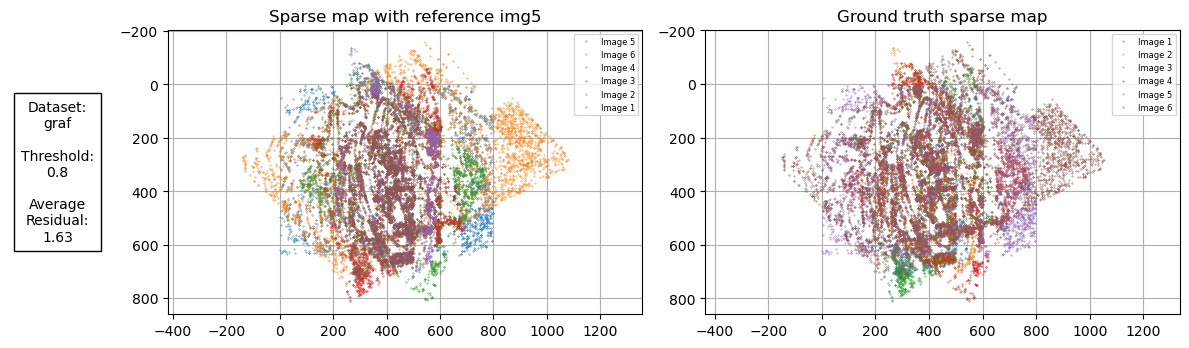

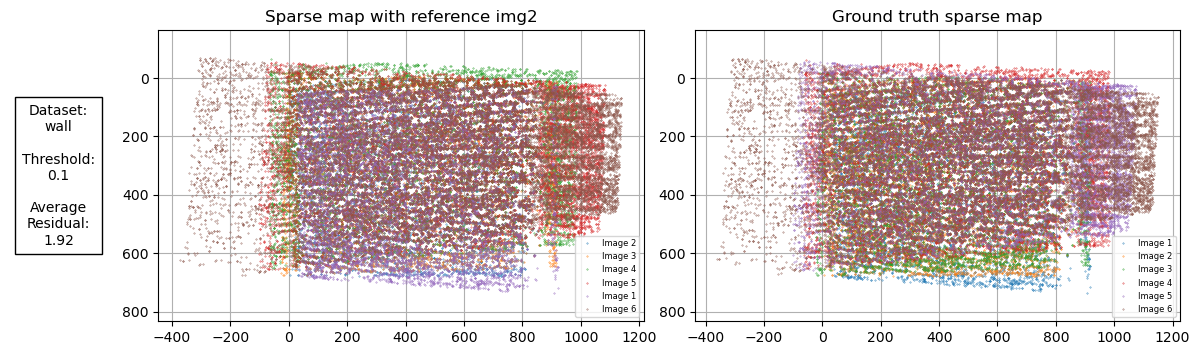

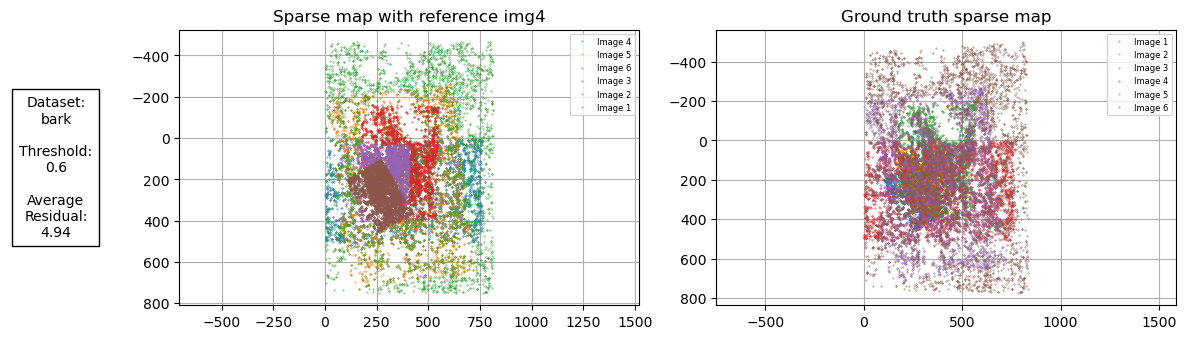

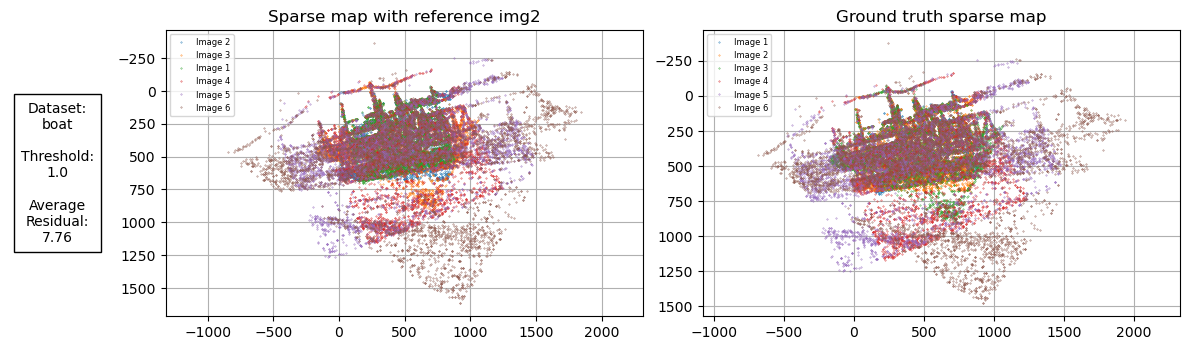

In [8]:
folders = ['graf', 'wall', 'bark', 'boat']
thresholds = {
    'graf': 0.8,
    'wall': 0.1,
    'bark': 0.6,
    'boat': 1.0
}
images_num = 6

dataset_images = {}

for folder in folders:
    images = []
    for col in range(images_num):
        image_type = 'pgm' if folder == 'boat' else 'ppm'
        image_path = os.path.join('data', folder, f"img{col+1}.{image_type}")
        try:
            image = read_as_grayscale(image_path)
            images.append(image)
        except Exception as e:
            print(f"Failed to load {image_path}: {e}")
    dataset_images[folder] = images

for dataset_name, images in dataset_images.items():
    threshold = thresholds.get(dataset_name)
    ref_image, homographies_glob, keypoints, _ = run_structure_from_motion(images, threshold)
    folder_path = os.path.join("data", dataset_name)
    homographies_ground_truth = load_ground_truth(folder_path, ref_image)

    # Compute average residual
    residual_average = compute_average_residual(homographies_glob, homographies_ground_truth, keypoints, len(images))

    # Create subplot layout
    fig = plt.figure(figsize=(12, 4))
    gs = GridSpec(1, 3, width_ratios=[0.2, 1, 1])
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])
    ax3 = fig.add_subplot(gs[2])

    # Metadata Text
    ax1.axis("off")
    ax1.text(0.5, 0.5,
        f"Dataset:\n{dataset_name}\n\nThreshold:\n{threshold}\n\nAverage\nResidual:\n{residual_average:.2f}",
        fontsize=10, ha="center", va="center",
        bbox=dict(boxstyle="square,pad=0.5", facecolor="white", edgecolor="black")
             )
    # Plot sparse map
    ax2.set_box_aspect(3/5)
    sparse_map(ref_image, homographies_glob, keypoints, dataset_name, ax2)
    # Plot ground truth sparse map
    ax3.set_box_aspect(3/5)
    ground_truth_sparse_map(homographies_ground_truth, keypoints, dataset_name, ax3)

    plt.tight_layout()
    plt.subplots_adjust(top=0.8)

    save_name = f"exp_{dataset_name}_{threshold}.png" 
    save_path = os.path.join('experiment/subexperiment', save_name) 
    plt.savefig(save_path, bbox_inches="tight", dpi=300) 
 
    plt.show()